In [3]:
import sys
!conda install --yes --prefix {sys.prefix} requests
!conda install --yes --prefix {sys.prefix} bs4

import requests #package for http requests
import bs4 # package for html parsing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
current = 2021
years = list(range(current, current - 72, -1))

In [5]:
race_results = pd.DataFrame()
for year in years:
    link = 'https://www.formula1.com/en/results.html/'+str(year)+'/races.html'
    source = requests.get(link)
    soup = bs4.BeautifulSoup(source.text,'lxml')
    table = soup.find_all('table')[0] 
    df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
    df['Year'] = year
    race_results = race_results.append(df,ignore_index=True)
race_results = race_results[['Grand Prix','Date','Winner','Car','Laps','Time','Year']]

In [6]:
driver_results = pd.DataFrame()
for year in years:
    dlink = 'https://www.formula1.com/en/results.html/'+str(year)+'/drivers.html'
    dsource = requests.get(dlink)
    dsoup = bs4.BeautifulSoup(dsource.text,'lxml')
    dtable = dsoup.find_all('table')[0] 
    ddf = pd.read_html(str(dtable), flavor='bs4', header=[0])[0]
    ddf['Year'] = year
    driver_results = driver_results.append(ddf,ignore_index=True)
driver_results = driver_results[['Pos','Driver','Nationality','Car','PTS','Year']]

In [7]:
driver_salaries = pd.DataFrame()
for year in ['2021','2020','2019','2018']:

    slink = 'https://www.spotrac.com/formula1/'+str(year)+'/'
    ssource = requests.get(slink)
    ssoup = bs4.BeautifulSoup(ssource.text,'lxml')
    rows = ssoup.find_all('tr') 
    drivers =[]
    for row in range(len(rows)):
        drivers_row = []
        columns = rows[row].findAll('td')
        for column in columns:
            drivers_row.append(column.getText())
        drivers.append(drivers_row)
    salaries = pd.DataFrame(drivers).dropna()
    salaries['Year']=year
    driver_salaries = driver_salaries.append(salaries,ignore_index=True)   
    
new_colnames = ['Driver','Age','Country','Salary','Year']
driver_salaries.columns = new_colnames
driver_salaries['Driver'] = [row.strip() for row in driver_salaries['Driver']]

In [8]:
driver_results['Driver'] = driver_results['Driver'].str.rsplit(' ',1).str[0]
driver_results['Driver'] = driver_results['Driver'].str.replace('  ', ' ')
driver_results['Driver'] = driver_results['Driver'].str.replace('   ', ' ')
driver_results['Driver'] = driver_results['Driver'].str.replace('RÃ¤ikkÃ¶nen','Raikkonen')
race_results['Winner'] = race_results['Winner'].str.rsplit(' ',1).str[0]

In [9]:
salaries_by_year = pd.read_csv('C:\\Users\\ashto\\Desktop\\Salaries.csv')

In [10]:
salaries_by_year = salaries_by_year[['Driver','Salary','Year']]
salaries_by_year.head()

,Driver,Salary,Year
0,Kimi Raikkonen,7525000,2021
1,Antonio Giovinazzi,684000,2021
2,Fernando Alonso,20500000,2021
3,Esteban Ocon,4652000,2021
4,Sebastian Vettel,17000000,2021


In [11]:
#results_by_salary = driver_results.merge(salaries_by_year,how='left',on=['Driver','Year'])
results_by_salary= salaries_by_year.merge(driver_results,on=['Driver','Year'])

Coef: [0.00740695]
inter: 147144.47419705326


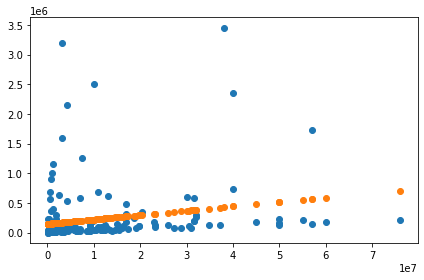

In [12]:
#analyze cost per point
results_by_salary['Cost per Point'] = results_by_salary['Salary']/results_by_salary['PTS']
n = results_by_salary[results_by_salary['Cost per Point']!=np.inf]
x=n[['Salary']].dropna()
y=n['Cost per Point'].dropna()
plt.scatter(x,y)
#avg salary/points per player

#regression
regressor = LinearRegression()
regressor.fit(x,y)
ypred = regressor.predict(n[['Salary']])

print("Coef:",regressor.coef_)
print("inter:",regressor.intercept_)
plt.scatter(x,ypred)
plt.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x1c187a846d0>,
 [Text(1, 0, 'Red Bull'),
  Text(2, 0, 'Ferrari'),
  Text(3, 0, 'Mercedes'),
  Text(4, 0, 'Renault')])

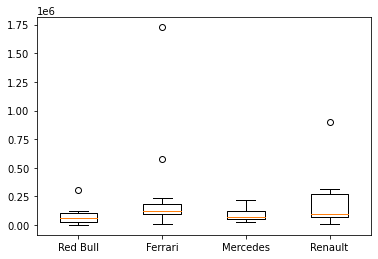

In [13]:
n[n['Cost per Point']==max(y)]
n[n['Cost per Point']==min(y)]

red_bull = n[n['Car']=='Red Bull Racing Honda']
ferrari = n[n['Car']=='Ferrari']
mercedes = n[n['Car']=='Mercedes']
renault = n[n['Car']=='Renault']
plt.boxplot([red_bull['Cost per Point'],
             ferrari['Cost per Point'],
             mercedes['Cost per Point'],
             renault['Cost per Point']
            ])
labels = ('Red Bull', 'Ferrari','Mercedes','Renault')
plt.xticks(np.arange(len(labels))+1,labels)


Text(0.5, 1.0, 'Cost per Point by Car')

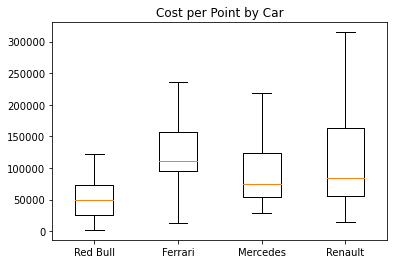

In [14]:
#remove outliers
def remove_outlier(df):
    Q1 = df['Cost per Point'].quantile(0.25)
    Q3 = df['Cost per Point'].quantile(0.75)
    IQR = Q3 - Q1
    filter = df[(df['Cost per Point'] >= Q1 - 1.5 * IQR) & (df['Cost per Point'] <= Q3 + 1.5 *IQR)]
    return filter

red_bull_no = remove_outlier(red_bull)
ferrari_no= remove_outlier(ferrari)
mercedes_no= remove_outlier(mercedes)
renault_no= remove_outlier(renault)

plt.boxplot([red_bull_no['Cost per Point'],
             ferrari_no['Cost per Point'],
             mercedes_no['Cost per Point'],
             renault_no['Cost per Point']
            ])
labels = ('Red Bull', 'Ferrari','Mercedes','Renault')
plt.xticks(np.arange(len(labels))+1,labels)
plt.title("Cost per Point by Car")

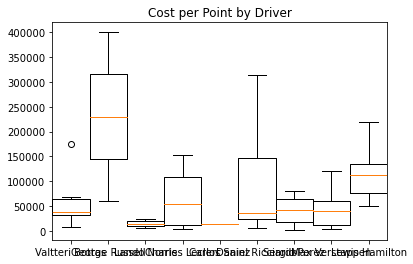

In [15]:
#top ten racers

vb = n[n['Driver']=='Valtteri Bottas']
gr = n[n['Driver']=='George Russell']
ln = n[n['Driver']=='Lando Norris']
cl = n[n['Driver']=='Charles Leclerc']
cs = n[n['Driver']=='Carlos Sainz']
dr = n[n['Driver']=='Daniel Ricciardo']
sp = n[n['Driver']=='Sergio Perez']
mv = n[n['Driver']=='Max Verstappen']
lh = n[n['Driver']=='Lewis Hamilton']

plt.boxplot([vb['Cost per Point'],
             gr['Cost per Point'],
             ln['Cost per Point'],
             cl['Cost per Point'],
             cs['Cost per Point'],
             dr['Cost per Point'],
             sp['Cost per Point'],
             mv['Cost per Point'],
             lh['Cost per Point']
            ],widths=(1, 1, 1, 1,1,1,1,1,1))
newlabels = ('Valtteri Bottas','George Russell','Lando Norris','Charles Leclerc','Carlos Sainz','Daniel Ricciardo',
          'Sergio Perez','Max Verstappen','Lewis Hamilton')
plt.xticks(np.arange(len(newlabels))+1,newlabels)
plt.title("Cost per Point by Driver")
plt.show()

In [16]:
race_results.head()

,Grand Prix,Date,Winner,Car,Laps,Time,Year
0,Bahrain,28 Mar 2021,Lewis Hamilton,Mercedes,56.0,1:32:03.897,2021
1,Emilia Romagna,18 Apr 2021,Max Verstappen,Red Bull Racing Honda,63.0,2:02:34.598,2021
2,Portugal,02 May 2021,Lewis Hamilton,Mercedes,66.0,1:34:31.421,2021
3,Spain,09 May 2021,Lewis Hamilton,Mercedes,66.0,1:33:07.680,2021
4,Monaco,23 May 2021,Max Verstappen,Red Bull Racing Honda,78.0,1:38:56.820,2021
